## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


find the number of rows in the dataset.

In [3]:
print("the no of rows in the dataset = ",df.shape[0])

the no of rows in the dataset =  294478


The number of unique users in the dataset.

In [4]:
print("the no of unique users in the dataset = ",df.user_id.nunique())

the no of unique users in the dataset =  290584


The proportion of users converted.

In [5]:
print("The proportion of users converted in the dataset = ",df["converted"].mean())

The proportion of users converted in the dataset =  0.119659193556


The number of times the `new_page` and `treatment` don't match.

In [6]:
d = df.query('(group == "treatment" and landing_page == "old_page") or(group == "control" and landing_page == "new_page")')
print('Number of times new_page and treatment dont line up :: ',d.shape[0])

Number of times new_page and treatment dont line up ::  3893


Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [8]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or(group == "control" and landing_page == "old_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [10]:
print("no of unique ids ",df2.user_id.nunique())

no of unique ids  290584


is there any duplicates? 

In [11]:
print("the dublicate id is ",df2[df2.user_id.duplicated()].user_id)

the dublicate id is  2893    773192
Name: user_id, dtype: int64


What is the row information for the repeat **user_id**? 

In [12]:
print("the dublicate id information ",df2[df2.user_id.duplicated()])

the dublicate id information        user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


Removeing **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset ="user_id",inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.



What is the probability of an individual converting regardless of the page they receive?

In [14]:
df["converted"].mean()

0.11965919355605512

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [17]:
df2[df2["landing_page"]=="new_page"].shape[0]/df2.shape[0]

0.5000619442226688


Overall conversions: 0.1196

Control (old page) conversions: 0.1204 

Treatment (new page) conversions: 0.1188 

i don't think we have sufficient evidence to conclode that the new treatment page leads to more conversions 
as the difference between the the probablity that people from treatment group convert and the probability that people from control group convert is very very small to make a decision based on it  
0.1203863045004612 - 0.11880806551510564 = 0.00157823898

<a id='ab_test'></a>
### Part II - A/B Test

because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now,I will consider I need to make the decision just based on all the data provided.


H[0] : **$p_{new}$**-**$p_{old}$**<=0                                                                                
H[1] : **$p_{new}$**-**$p_{old}$**>0

Lets assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore,lets assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Useing a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


the **conversion rate** for $p_{new}$ under the null

In [18]:
# the converted rate of the new page
p_new = df2.converted.mean()
p_new

0.11959708724499628

the **conversion rate** for $p_{old}$ under the null <br><br>

In [19]:
# the converted rate of the old page
p_old = df2.converted.mean()
p_old

0.11959708724499628

 $n_{new}$, the number of individuals in the treatment group

In [20]:
# the sample size of people with new page

n_new = df2[df2["group"]=="treatment"].shape[0]
n_new

145310

 $n_{old}$, the number of individuals in the control group

In [21]:
# the sample size of people with old page

n_old = df2[df2["group"]=="control"].shape[0]
n_old

145274

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  
Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# using random function to simulate binomial distribution for the new page convertion

new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new]).mean()
new_page_converted

0.12057669809373064

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  
Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# using random function to simulate binomial distribution for the old page convertion

old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old]).mean()
old_page_converted

0.12053774247284442

$p_{new}$ - $p_{old}$ for my simulated values.

In [24]:
# the differance between the simulated two groups

new_page_converted-old_page_converted

3.8955620886224618e-05

Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process i used above. 
Storing all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
# using numpy to simulate 10000 action for the new and old pages using binomial function

new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

Plot a histogram of the **p_diffs**.  

(array([    4.,    56.,   335.,  1197.,  2405.,  2834.,  2089.,   841.,
          204.,    35.]),
 array([-0.00474452, -0.00385526, -0.00296599, -0.00207673, -0.00118746,
        -0.0002982 ,  0.00059107,  0.00148033,  0.0023696 ,  0.00325886,
         0.00414813]),
 <a list of 10 Patch objects>)

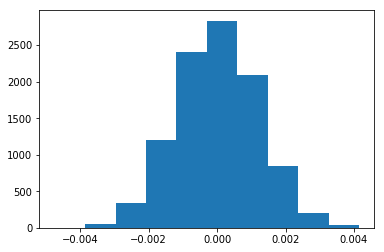

In [26]:
plt.hist(p_diffs)

proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [27]:
# calculating the actual difference between the two pages conversion

actual_diff = df2[df2["group"] == "treatment"]['converted'].mean() - df2[df2["group"] == "control"]['converted'].mean()
actual_diff

-0.0015782389853555567

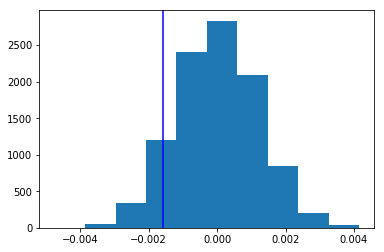

In [28]:
plt.hist(p_diffs)
plt.axvline(actual_diff, color='b')

In [29]:
# calculating the p value

p_diffs = np.array(p_diffs)
p_value = (p_diffs > actual_diff).mean()
p_value

0.90369999999999995


i choose alpha to be 0.05                                                                                           
so i have two results                                                                                                       
if p_value < 0.05 i can reject the null hypothesis                                                                           
if p_value > 0.05 i can't reject the null hypothesis

as p_value = 0.907 whic is >> 0.05                                                                                          
so i can't reject the null hypothesis                                                                              
and 
so p_new <= p_old

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [30]:
import statsmodels.api as sm

converted_old = df2[df2.landing_page == 'old_page'][df2.converted == 1].shape[0]
converted_new = df2[df2.landing_page == 'new_page'][df2.converted == 1].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Now useing `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([converted_old, converted_new], [n_old, n_new], alternative='smaller')
print('z_score : ',z_score)
print('p_value : ',p_value)

z_score :  1.31092419842
p_value :  0.905058312759


What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?


it agrees with th findings that we can't reject the null hypothesis and there is no difference between the old page and the new one

<a id='regression'></a>
### Part III - A regression approach


The goal is to use **statsmodels** to fit the regression model i specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, i first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
# converting group column from categorical to dummy variables

df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# adding intercept column with default value equal 1

df2['intercept'] = 1
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


Useing **statsmodels** to instantiate my regression model on the two columns i created., then fit the model using the two columns i created .** to predict whether or not an individual converts. 

In [35]:
# fitting the model using the two columns

import statsmodels.api as sm
import scipy.stats as stats
logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Providing the summary of my model below.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-15 16:08 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 


hypothesis in part 11                                                                                               
H0 p_new-p_old<=0   

H1 p_new-p_old>0  

which is one sided test 

hypothesis in part 111       

H0 p_new=p_old    

H1 p_new!=p_old

which is two sided test                                                                                           
                          
                          
thats why we see different p-value                                                                                but in both cases we can't reject null hypothesis                                                                which means in both cases the old page is better 

Now, I am considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


as we saw control and treatment page didn't impact our result sigificantly and it's not clear yet ,It is a good idea to consider other factors that may help to avoid the Simpson's paradox. Taking other factors into account might bring to light things that we missed out.

yes it could be bad 

if we added too many features our model can suffer from overfitting and high variance 
and we maybe add outliers or noise 



Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. I will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 


In [37]:
# adding new data to the original dataframe

countries = pd.read_csv('countries.csv')
df_new = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
countries_dummies = pd.get_dummies(df_new['country'])
df_countries = df_new.join(countries_dummies)
df_countries = df_countries.drop('US', axis=1)
df_countries.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [39]:
# fitting the model using countries columns

logit = sm.Logit(df_countries['converted'], df_countries[['intercept', 'CA', 'UK']])
results = logit.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-15 16:08 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

tha conclusion as the p-values indicates 
all countries p-values are larger than 0.05 
which means that countries are not statistically significant 

In [40]:
# creating new columns as the country with the pages 

df_countries['CA_new'] = df_countries['CA'] * df_countries['ab_page']
df_countries['UK_new'] = df_countries['UK'] * df_countries['ab_page']
mod = sm.Logit(df_countries['converted'], df_countries[['intercept', 'CA_new', 'UK_new']])
results = mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-15 16:08 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
CA_new       -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_new        0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

####    as we see in the p values of the two columns
####    the p value of the column ca_new is less than 0.05 so its statisticaly sigificant to the the results 
####    the p value of the column uk_new is more than 0.05 so its not statisticaly sigificant to the the results 

# conclosion                          <br>

### at the end we can't reject the null hypothesis 
### and i recommend to use the old page